In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import numpy as np
import random
from sklearn import preprocessing
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import time
from datetime import datetime
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers



# Settings the warnings to be ignored
import warnings  
warnings.filterwarnings('ignore') 

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Variables
run = datetime.fromtimestamp(time.time()).strftime("%Y.%m.%d-%H%M")
optimizer = 'SGD'
scale = 100
batch_size = 16
epochs = 32
augumentation = 'No'
regularizer = 0.001
data = 'Updated'
grayscale = 'Yes'

In [3]:
if data == 'Original':

    training_dir = '../data/training'
    val_dir = '../data/validation'
    testing_dir = '../data/testing'

else:

    training_dir = '../data/updated_training'
    val_dir = '../data/updated_validation'
    testing_dir = '../data/updated_testing'

In [4]:
img_width, img_height = scale, scale

In [5]:
if augumentation == 'No':
    
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

else:
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
if grayscale == 'No':
    color_channels = 3    
    train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42
    )

    test_generator = test_datagen.flow_from_directory(
        testing_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42
    )

else:
    color_channels = 1
    train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed=42
    ) 
    
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed=42
    )

    test_generator = test_datagen.flow_from_directory(
        testing_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed=42
    )


Found 1701 images belonging to 3 classes.
Found 243 images belonging to 3 classes.
Found 486 images belonging to 3 classes.


In [7]:
# Set seeds for reproducibility
SEED = 42
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(SEED)
initializer = tf.keras.initializers.GlorotUniform(seed=SEED)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, color_channels),
kernel_regularizer=l2(regularizer), kernel_initializer=initializer))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(regularizer), kernel_initializer=initializer))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(regularizer), kernel_initializer=initializer))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(regularizer), kernel_initializer=initializer))
model.add(Dropout(0.2))
# minor moderate and severe (3)
model.add(Dense(3, activation='softmax', kernel_regularizer=l2(regularizer), kernel_initializer=initializer))

In [ ]:
model.compile(optimizer=optimizer,  loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,587 (6.61 MB)

 Trainable params: 1,731,587 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Set seeds for reproducibility
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()


# get the start time
st = time.time()

history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st

Epoch 1/32
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.3295 - loss: 1.4982 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3333 - val_loss: 1.4832 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/32
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.3580 - loss: 1.4788 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5021 - val_loss: 1.4732 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/32
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.4051 - loss: 1.4723 - precision: 0.0139 - recall: 1.6382e-05 - val_accuracy: 0.4609 - val_loss: 1.4543 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/32
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.4410 - loss: 1.4493 - precision: 0.4774 - recall: 0.0035 - val_accuracy: 0.5103 - val_loss: 1.4166 - val_precision: 0.6667 - val_recall: 0.0082
Epoch 5/32
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.4766 - loss: 1.4050 - precision: 0.

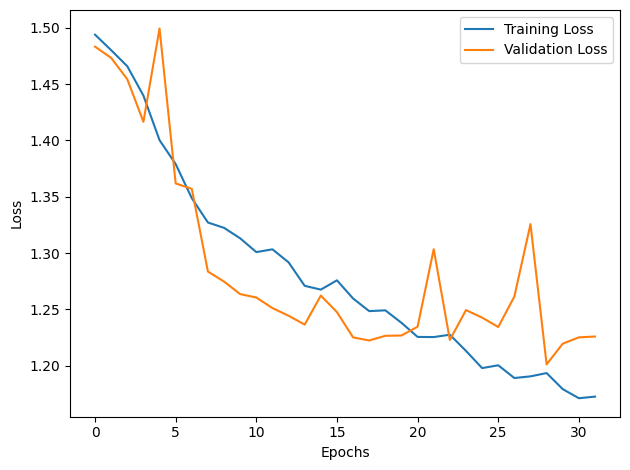

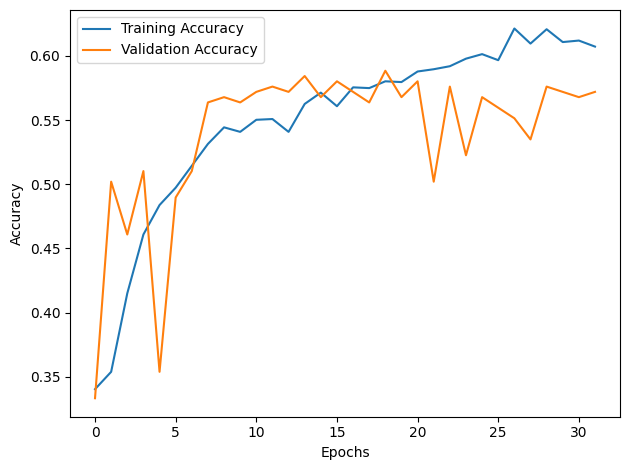

In [11]:
# loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig(f'../images/{run}-loss.png', dpi=300)
plt.show()

# accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(f'../images/{run}-accuracy.png', dpi=300)
plt.show()


 3/54 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step 

2024-12-02 22:22:22.457718: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-02 22:22:22.458187: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step


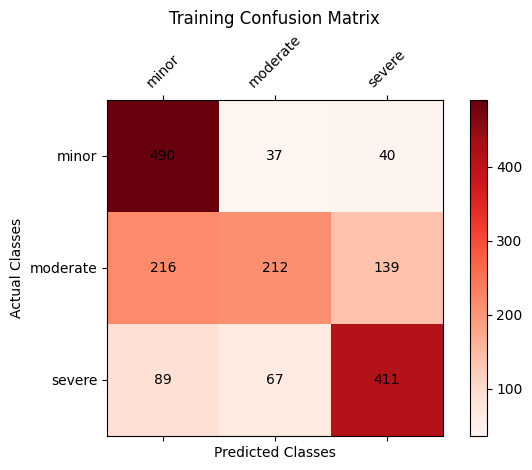

Training Classification Report:
              precision    recall  f1-score   support

    01-minor       0.62      0.86      0.72       567
 02-moderate       0.67      0.37      0.48       567
   03-severe       0.70      0.72      0.71       567

    accuracy                           0.65      1701
   macro avg       0.66      0.65      0.64      1701
weighted avg       0.66      0.65      0.64      1701



In [12]:
train_images, train_labels = [], []
class_names = sorted(train_generator.class_indices.keys())
for i in range(len(train_generator)):
    images, labels = train_generator[i]
    train_images.extend(images)
    train_labels.extend(np.argmax(labels, axis=1))


train_images = np.array(train_images)
train_labels = np.array(train_labels)

predictions = model.predict(train_images)

y_pred = np.argmax(predictions, axis=1)
y_true = train_labels

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap='Reds')

cbar = fig.colorbar(cax)

ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45)
ax.set_yticklabels([''] + ['minor', 'moderate', 'severe'])

ax.set_xlabel('Predicted Classes')
ax.set_ylabel('Actual Classes')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha='center', va='center')


plt.title('Training Confusion Matrix')
plt.tight_layout()
plt.savefig(f'../images/{run}-training-cm.png', dpi=300)
plt.show()

train_report = classification_report(y_true, y_pred, target_names=class_names)
print('Training Classification Report:')
print(train_report)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


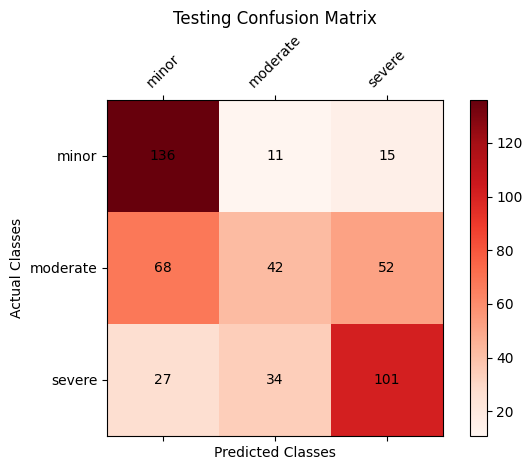

testing Classification Report:
              precision    recall  f1-score   support

    01-minor       0.59      0.84      0.69       162
 02-moderate       0.48      0.26      0.34       162
   03-severe       0.60      0.62      0.61       162

    accuracy                           0.57       486
   macro avg       0.56      0.57      0.55       486
weighted avg       0.56      0.57      0.55       486



In [13]:
test_images, test_labels = [], []
class_names = sorted(test_generator.class_indices.keys())
for i in range(len(test_generator)):
    images, labels = test_generator[i]
    test_images.extend(images)
    test_labels.extend(np.argmax(labels, axis=1))


test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = model.predict(test_images)

y_pred = np.argmax(predictions, axis=1)
y_true = test_labels

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap='Reds')

cbar = fig.colorbar(cax)

ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45)
ax.set_yticklabels([''] + ['minor', 'moderate', 'severe'])

ax.set_xlabel('Predicted Classes')
ax.set_ylabel('Actual Classes')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha='center', va='center')

plt.title('Testing Confusion Matrix')
plt.tight_layout()
plt.savefig(f'../images/{run}-testing-cm.png', dpi=300)
plt.show()

test_report = classification_report(y_true, y_pred, target_names=class_names)
print('testing Classification Report:')
print(test_report)

In [14]:
result = pd.DataFrame.from_dict(history.history).tail(1)
result['F1_Score'] = ((2 * result['precision'] * result['recall']) / (result['precision'] + result['recall']))
result['val_F1_Score'] = ((2 * result['val_precision'] * result['val_recall']) / (result['val_precision'] + result['val_recall']))

result['Optimizer'] = optimizer
result['Epochs'] = epochs
result['Batch_Size'] = batch_size
result['Rescale'] = scale
result['Time(min)'] = elapsed_time/60
result['Run'] = run
result['Regularizer(L2)'] = regularizer
result['Augumentation'] = augumentation
result['Data'] = data
result['Grayscale'] = grayscale

columns = ['Run','Time(min)','Optimizer','Epochs','Batch_Size','Rescale','Regularizer(L2)','Data', 'Grayscale',
           'Augumentation','accuracy','loss','precision','recall','F1_Score', 'val_accuracy', 
           'val_loss','val_precision','val_recall','val_F1_Score']

result = result.reindex(columns=columns).reset_index(drop=True)

result

,Run,Time(min),Optimizer,Epochs,Batch_Size,Rescale,Regularizer(L2),Data,Grayscale,Augumentation,accuracy,loss,precision,recall,F1_Score,val_accuracy,val_loss,val_precision,val_recall,val_F1_Score
0,2024.12.02-2215,7.221078,SGD,32,16,100,0.001,Updated,Yes,No,0.60729,1.172646,0.688301,0.473839,0.561281,0.572016,1.22596,0.668831,0.423868,0.518892


In [15]:
# Load the existing CSV file into a DataFrame
existing_df = pd.read_csv('results.csv')

# Append the new DataFrame to the existing one
combined_df = pd.concat([existing_df, result], ignore_index=True)

# Save the updated DataFrame back to the same CSV file
combined_df.to_csv('results.csv', index=False)

In [16]:
combined_df

,Run,Time(min),Optimizer,Epochs,Batch_Size,Rescale,Regularizer(L2),Data,Augumentation,Grayscale,...,loss,precision,recall,F1_Score,val_accuracy,val_loss,val_precision,val_recall,val_F1_Score,Unnamed: 20
0,2024.11.20-2009,7.810579,SGD,32,16,100,NaN,Original,No,Yes,...,2.241912,0.665521,0.425641,0.519214,0.617021,2.189133,0.773438,0.421277,0.545455,NaN
1,2024.11.17-2200,7.309321,SGD,50,32,100,0.001,Original,No,Yes,...,1.150984,0.709000,0.519414,0.599577,0.608511,1.211403,0.683544,0.459574,0.549618,NaN
2,2024.11.17-1222,2.771039,SGD,32,32,100,NaN,Original,No,No,...,3.185605,0.671982,0.432234,0.526081,0.591489,3.188465,0.741071,0.353191,0.478386,NaN
3,2024.11.18-2125,9.404231,SGD,50,32,100,NaN,Updated,No,Yes,...,2.226537,0.704291,0.443857,0.544537,0.588477,2.236971,0.662577,0.444444,0.532020,NaN
4,2024.11.23-1239,14.158290,SGD,32,16,100,0.01,Updated,No,Yes,...,1.369934,0.662461,0.370370,0.475113,0.588477,1.324985,0.655629,0.407407,0.502538,"flipped architecture (128, 64, 32, 16, 3 neurons)"
5,2024.11.17-1215,2.763423,adam,32,32,100,NaN,Original,No,No,...,0.982818,0.676630,0.364835,0.474060,0.587234,0.950834,0.730159,0.391489,0.509695,NaN
6,2024.11.18-2136,9.698446,SGD,50,32,100,NaN,Updated,No,No,...,2.207097,0.716724,0.493827,0.584755,0.584362,2.259890,0.647799,0.423868,0.512438,NaN
7,2024.11.18-2049,10.003794,SGD,50,32,100,0.001,Updated,Yes,Yes,...,1.279316,0.667920,0.313345,0.426571,0.584362,1.203535,0.704225,0.411523,0.519481,NaN
8,2024.11.20-1918,9.190498,SGD,50,16,100,NaN,Original,No,Yes,...,1.595863,0.696502,0.495971,0.579375,0.582979,1.663156,0.679739,0.442553,0.536082,Momentum added
9,2024.11.17-1056,6.005655,adam,32,32,100,NaN,Original,Yes,No,...,1.017572,0.631957,0.257875,0.366285,0.582979,0.981662,0.742574,0.319149,0.446429,NaN
